# Übung 10

**Gruppenname:**

*Name Ihrer Gruppe*

Gehen Sie wie folgt vor:

1. Bitte benennen Sie jetzt dieses Jupyter Notebook um (z.B. über `File -> Rename`):

   Namensschema: `Gruppenname-X`. Ersetzen Sie "X" mit der oben angegebenen Nummer der Übung.

   - Beispiel 1: Team REZA bearbeitet Übung 2. Das Notebook heißt: REZA-2.
   - Beispiel 2: Sie sind keinem Team zugeordnet (nicht empfehlenswert) und bearbeiten Übung 2: Ihr Notebook heißt: Nachname-2.


2. Tragen Sie Ihren Gruppennamen auch ganz oben bei "Name Ihrer Gruppe" ein.

3. Bearbeiten Sie dann dieses Notebook. Vergessen Sie dabei nicht, das Jupyter Notebook regelmäßig zu speichern (z.B. über `Strg + S` oder über `File -> Save and Checkpoint`).

### Hinweise
* Nutzen Sie für die folgenden Aufgaben **nur** die Mittel, die Ihnen Numpy und Matplotlib zur Verfügung stellt.

### 10.1 Least Squares Support Vector Machine (LS-SVM)

In der Vorlesung haben Sie die LS-SVM als eine Variante der Support Vector Machine (SVM) kennengelernt, die sich einfacher implementieren lässt. Sie werden im Rahmen dieser Übung die LS-SVM mit einem Gaußschen RBF-Kernel implementieren und testen. Nutzen Sie für die Implementierung Befehle der Numpy-Bibliothek.

**Ihre Aufgaben**

(1) Schlagen Sie in den Vorlesungsfolien nach, wie die LS-SVM zu implementieren ist: Identifizieren Sie die 5 Schritte, die Sie für die Implementierung durchführen müssen.

(2) Führen Sie die unten stehende Code-Zelle aus, um Hilfsfunktionen und Ihre Trainings- und Testdaten zu importieren.

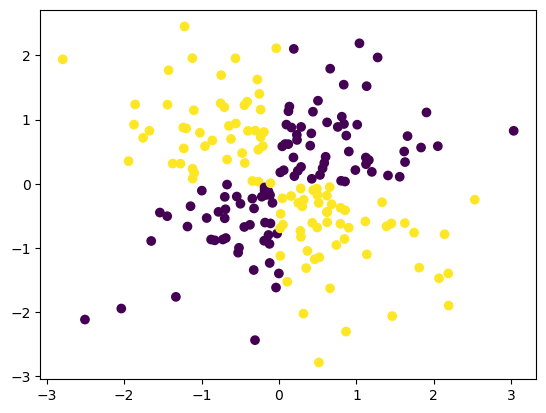

In [21]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# helper function to plot decision boundaries
def plot_decision_regions(X, y, classifier, resolution=0.02, axis=None):
    if X.shape[1] != 2:
        raise ValueError(
            f'Die Daten dürfen maximal 2 Features besitzen. Es wurden aber Daten mit {X.shape[1]} Features übergeben.')
    axis = axis if axis is not None else plt.gca()

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Handle both callable and object with predict method
    if callable(classifier):
        Z = classifier(np.array([xx1.ravel(), xx2.ravel()]).T)
    elif hasattr(classifier, 'predict'):
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    else:
        raise ValueError('classifier must be callable or have a predict method')
    
    Z = Z.reshape(xx1.shape)
    Zmax = np.abs(Z).max()
    axis.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap, levels=[-Zmax, 0, Zmax])
    axis.set_xlim(xx1.min(), xx1.max())
    axis.set_ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        axis.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                     alpha=0.8, c=np.expand_dims(cmap(idx), 0),
                     marker=markers[idx], label=cl)

# function to generate the data set
def get_data():
    # create data set with training and test set
    np.random.seed(1)
    X = np.random.randn(300, 2)
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
    y = np.where(y, 1, -1)

    # split data
    X_train = X[:200, :]
    y_train = y[:200].reshape(-1, 1)

    X_test = X[200:, :]
    y_test = y[200:].reshape(-1, 1)

    return X_train, y_train, X_test, y_test

# X_train: (N x d) matrix containing N feature vectors with d features each
X_train, y_train, X_test, y_test = get_data()

# visualize data
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

(3) Wie viele Featurevektoren ($N$) hat Ihr Trainingsdatensatz? Wie viele Features ($D$) hat jeder Featurevektor?

In [5]:
N, D = X_train.shape

(4) Der Gaußsche RBF-Kernel für zwei Vektoren $\mathbf{x}$ und $\mathbf{x}^\prime$ ist definiert als:

$$K(\mathbf{x},\mathbf{x}^\prime) := \exp \left( -\frac{ \lVert \mathbf{x} - \mathbf{x}^\prime\rVert^2}{2\sigma^2} \right)$$

Implementieren Sie nun die Kernel**matrix** $K$ für einen Gaußschen RBF-Kernel: Schreiben Sie dazu eine Funktion `kernel_rbf`, die drei Argumente entgegennimmt: $X$, $X^\prime$ und $\sigma$.

- $X$ sei ein $N_1\times D$ Array.
- $X^\prime$ sei ein $N_2\times D$ Array.

Die Arrays enthalten also $N_1$ bzw. $N_2$ Featurevektoren.

Ihre Funktion `kernel_rbf` gibt die Kernelmatrix $K$ zurück. Es handelt sich um eine $N_1 \times N_2$ Matrix.

- Tipp: Vielleicht hilft Ihnen [diese Funktion](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) bei Ihrer Implementierung.

In [29]:

def rbf(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

def kernel_rbf(X, X_prime=None, sigma=None):
    if sigma is None:
        sigma = np.std(X)
    
    # If X_prime is not provided, compute kernel matrix for X with itself
    if X_prime is None:
        X_prime = X
    
    # Use broadcasting to compute all pairwise distances efficiently
    # X: (N1, D), X_prime: (N2, D)
    # Expand dimensions: X becomes (N1, 1, D), X_prime becomes (1, N2, D)
    # Result after subtraction: (N1, N2, D)
    diff = X[:, np.newaxis, :] - X_prime[np.newaxis, :, :]
    # Compute squared norms along the last axis: (N1, N2)
    sq_dists = np.sum(diff**2, axis=2)
    # Apply RBF kernel formula
    K = np.exp(-sq_dists / (2 * sigma**2))
    
    return K

kernel_rbf(X_train)

array([[1.00000000e+00, 7.86796532e-02, 1.65268827e-01, ...,
        8.99352723e-03, 4.76307373e-04, 4.82804506e-03],
       [7.86796532e-02, 1.00000000e+00, 1.63535455e-01, ...,
        1.41204976e-01, 4.81170980e-02, 4.31963004e-03],
       [1.65268827e-01, 1.63535455e-01, 1.00000000e+00, ...,
        1.01025986e-03, 8.42761702e-05, 2.39721754e-05],
       ...,
       [8.99352723e-03, 1.41204976e-01, 1.01025986e-03, ...,
        1.00000000e+00, 6.78058260e-01, 2.41892241e-01],
       [4.76307373e-04, 4.81170980e-02, 8.42761702e-05, ...,
        6.78058260e-01, 1.00000000e+00, 8.08763037e-02],
       [4.82804506e-03, 4.31963004e-03, 2.39721754e-05, ...,
        2.41892241e-01, 8.08763037e-02, 1.00000000e+00]], shape=(200, 200))

(5) Die Kernelmatrix muss die Dimension $N_1 \times N_2$ besitzen. Prüfen Sie mithilfe Ihrer Trainingsdaten `X_train` und `X_test`, ob Ihre Kernelmatrix die richtige Dimension aufweist:

- Welche Dimensionalität erwarten Sie für die Kernelmatrix, die Sie auf den Trainingsdaten berechnen? (`kernel_rbf(X_train, X_train, 1)`)?

- Welche Dimensionalität erwarten Sie für die Kernelmatrix, die Sie auf den Trainings- und Testdaten berechnen? (`kernel_rbf(X_train, X_test, 1)`)?

Wenn Ihre Kernel-Matrix nicht die Dimension aufweist, die Sie erwarten, gehen Sie zu Schritt (4) zurück und überprüfen Ihre Implementierung.

(6) Implementieren Sie nun eine Funktion `omega(X, y, sigma)`, die einen $N\times 1$ dimensionalen Labelvektor $\mathbf{y}$ sowie ein $N\times D$ Array `X` mit Featurevektoren sowie $\sigma$ entgegennimmt, und die Matrix $\Omega$ zurückgibt:

$$ \Omega = \mathbf{y}\mathbf{y}^\text{T}\odot K$$

Beachten Sie:

- $\mathbf{y}\mathbf{y}^\text{T}$ ist ein [äußeres (=dyadisches) Produkt](https://de.wikipedia.org/wiki/Dyadisches_Produkt), welches eine Matrix erzeugt.
- $\odot$ bedeutet: Es werden die Elemente der beiden Matrizen elementweise multipliziert ([Hadamard-Produkt](https://de.wikipedia.org/wiki/Hadamard-Produkt)). Dies ist also keine normale Matrixmultiplikation.
- $K$ ist die Kernelmatrix, die Sie mit dem Aufruf `kernel_rbf(X, X, sigma)` erzeugen.

Tipp:

- Diese [Funktion](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html) könnte für Sie nützlich sein.

In [30]:
def omega(X, y, sigma):
    if sigma is None:
        sigma = np.std(X)
    K = kernel_rbf(X, X, sigma)  # X with itself for the training data
    return np.multiply(y @ y.T, K)  # Hadamard (element-wise) product

Omega = omega(X_train, y_train, None)

(7) Betrachten Sie die Definition von $\Omega$ aus Schritt (6): Welche Dimensionalität muss $\Omega$ haben? Prüfen Sie nach, ob der Aufruf `omega(X_train, y_train, 1)` eine Matrix mit der von Ihnen erwarteten Dimensionalität zurückgibt.

- Wenn Sie einen Widerspruch zu Ihren Erwartungen feststellen, gehen Sie zu Schritt (6) zurück und überprüfen Ihre Implementierung.

(8) Betrachten Sie nun das folgende Gleichungssystem:

$$
	\underbrace{\left[
	\begin{array}{c|c}
		0 & \mathbf{y}^\text{T} \\
		\hline
		\mathbf{y} & \Omega + I/\gamma
	\end{array}
	\right]}_{A}
	\underbrace{\left[
	\begin{array}{c}
		b \\
		\hline
		\vec{\alpha}
	\end{array}
	\right]}_{\mathbf{s}}
	=
	\underbrace{\left[
	\begin{array}{c}
		0 \\
		\hline
		\mathbf{1}
	\end{array}
	\right]}_{\mathbf{z}}
$$

Implementieren Sie nun die Matrix `A`. Damit Sie Ihre Implementierung testen können, setzen Sie beispielhaft für die Daten `X_train`, `y_train` sowie für die Parameter `sigma=1` und `gamma=1` ein. Nutzen Sie Ihre Funktion `omega`, die Sie in Schritt (6) implementiert hatten.

Hinweis:

- Nutzen Sie [np.block](https://numpy.org/doc/stable/reference/generated/numpy.block.html), um die Blockstruktur der Matrix $A$ zu erzeugen, sowie [np.identity](https://numpy.org/doc/stable/reference/generated/numpy.identity.html), um die Identitätsmatrix $I$ zu erzeugen.

In [9]:
def get_A(X, y, sigma, gamma):
    # Calculate Omega matrix
    Omega = omega(X, y, sigma)
     
    A = np.block([
        [np.array([[0]]), y.reshape(1, -1)],
        [y.reshape(-1, 1), Omega + (1/gamma) * np.eye(Omega.shape[0])]
    ])
    
    return A

# Test with the example parameters
A = get_A(X_train, y_train, sigma=1, gamma=1)
print(f"Shape of A: {A.shape}")
print(f"Expected shape: ({len(y_train)+1}, {len(y_train)+1})")

Shape of A: (201, 201)
Expected shape: (201, 201)


(9) Prüfen Sie die Dimensionalität Ihrer Matrix `A`. Hat Sie für die Trainingsdaten aus Schritt (8) die Form $(N_{train}+1)\times (N_{train}+1)$? Falls ja, können Sie fortfahren. Falls nein, gehen Sie bitte zu Schritt (8) und überprüfen Ihre Implementierung.

In [10]:
print(X_train.shape)

(200, 2)


(10) Implementieren Sie nun testweise den Vektor $\mathbf{z}$ aus folgendem Gleichungssystem für die Trainingsdaten:

$$
	\underbrace{\left[
	\begin{array}{c|c}
		0 & \mathbf{y}^\text{T} \\
		\hline
		\mathbf{y} & \Omega + I/\gamma
	\end{array}
	\right]}_{A}
	\underbrace{\left[
	\begin{array}{c}
		b \\
		\hline
		\vec{\alpha}
	\end{array}
	\right]}_{\mathbf{s}}
	=
	\underbrace{\left[
	\begin{array}{c}
		0 \\
		\hline
		\mathbf{1}
	\end{array}
	\right]}_{\mathbf{z}}
$$

Tipps:

- Vielleicht sind für Sie [diese Funktion](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) und [jene Funktion](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) bei der Implementierung hilfreich.

- Testen Sie, ob Sie $\mathbf{z}$ richtig implementiert haben mit Ihren Trainingsdaten. Der Vektor $\mathbf{z}$ muss die Dimensionalität $(N_\text{train}+1)\times 1$ aufweisen. Überarbeiten Sie Ihren Code, bis dies der Fall ist.

In [11]:
def return_z():
    return np.block([[0], [np.ones((N, 1))]])

(11) Berechnen Sie den Lösungsvektor $\mathbf{s}$, indem Sie die Inverse der Matrix A bestimmen:

$$\mathbf{s} = \left[
	\begin{array}{c}
		b \\
		\hline
		\vec{\alpha}
	\end{array}
	\right] = A^{-1} \mathbf{z}$$

Tipps:

- Hier können Ihnen [diese Funktion](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) und [jene Funktion](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) hilfreich sein.
- Für Ihre Trainingsdaten muss der Vektor $\mathbf{z}$ die Dimension $(N_\text{train}+1)\times 1$ aufweisen. Prüfen Sie dies!

In [12]:
sol = np.linalg.solve(A, return_z())

(12) Gewinnen Sie aus dem Lösungsvektor $\mathbf{s}$ aus dem vorherigen Schritt die Parameter `b` ($b$) und `alpha` ($\vec{\alpha}$).

In [13]:
alpha = sol[1::]
b = sol[0]

(13) Implementieren Sie nun eine Funktion mit dem Namen `lssvm(X, y, sigma, gamma)`, die Ihre Schritte (8) bis (12) kombiniert. Ihre Funktion nimmt die allgemeinen Featurevektoren (Datenarray) `X` sowie den dazugehörigen Labelvektor `y` und die Parameter `sigma` und `gamma` entgegen, und gibt die Parameter `alpha` und `b` zurück:

`alpha, b = lssvm(X, y, sigma, gamma)`

Hinweis:

- Achten Sie darauf, dass Sie die Schritte (8) bis (12) nun allgemein ausformulieren, also dass Sie nicht mehr mit den konkreten Trainingsdaten arbeiten.

In [14]:
def lssvm(X, y, sigma, gamma):
    A = get_A(X ,y, sigma, gamma)
    z = return_z()

    sol = np.linalg.solve(A, z)
    alpha = sol[1::]
    b = sol[0]

    return alpha, b



(14) Implementieren Sie nun die Funktion `predict(X_train, X_test, y_train, alpha, b, sigma)`, die die vorhergesagten Labels `y` für die Testdaten `X_test` zurückgibt.

Die durch die LS-SVM vorhergesagten Labels erhalten Sie über:

$$ y(x) = \text{sign} \left[\sum_{k=1}^N \alpha_k y_k K(x_k, x) + b \right] $$

Hinweise:

- Ihre `predict` Funktion gibt einen Labelvektor $\mathbf{y}$ der Dimension $(N_\text{test}\times 1)$ zurück. Dies bedeutet, Ihre Funktion bestimmt für jeden Featurevektor in `X_test` das vorhergesagte Label.
- Rufen Sie in Ihrer `predict` Funktion Ihre vor einigen Schritten selbst implementierte `kernel_rbf` Funktion auf.
- **Wichtig:** Ihre `predict` Funktion wird in der nachfolgenden Teilaufgabe indirekt sehr häufig aufgerufen, um die Entscheidungsgrenzen Ihrer LS-SVM zu visualisieren. Dazu muss `predict` effizient implementiert werden: Vermeiden Sie bei der Implementierung von `predict` die Nutzung von Schleifen. Nutzen Sie stattdessen Funktionalität von *numpy*, mit der Sie Vektoroperationen direkt ausführen lassen können, wie z.B. [multiply](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html). Dieses sogenannte vektorisierte Ausführen ist deutlich schneller als die Ausführung von Schleifen. Wenn Sie diesen Hinweis nicht beachten, dann kann die Berechnung der nächsten Teilaufgabe viele (>15) Minuten dauern.

In [32]:
def predict(X_train, X_test, y_train, alpha, b, sigma):
    # Compute kernel matrix between training and test data
    # K will be (N_train, N_test)
    K = kernel_rbf(X_train, X_test, sigma)
    
    # Vectorized computation: y = sign(K^T @ (alpha * y_train) + b)
    # alpha * y_train: (N_train, 1) element-wise multiplication
    # K.T: (N_test, N_train)
    # K.T @ (alpha * y_train): (N_test, 1)
    weighted_sum = K.T @ (alpha * y_train)
    
    # Add bias and apply sign function
    predictions = np.sign(weighted_sum + b)
    
    return predictions.ravel()


(15) Testen Sie Ihre Implementierung, indem Sie die untere Code-Zelle ausführen:

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

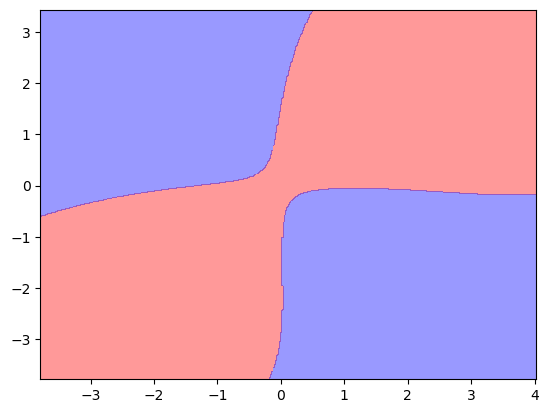

In [34]:
# select hyperparameters
sigma = np.sqrt(2)
gamma = 1

#train model (aquire lagrangian parameters)
alpha, b = lssvm(X_train, y_train, sigma, gamma)

# Create a wrapper function to use with plot_decision_regions
def classifier_predict(X_test_data):
    return predict(X_train, X_test_data, y_train, alpha, b, sigma)

# plot decision regions
plot_decision_regions(X_train, y_test, classifier_predict)
plt.show()

(16) \[Optional\] Testen Sie beispielhaft, wie sich die Entscheidungsgrenze für unterschiedliche Wahl des Kernel-Parameters `sigma` und für den Strafterm `gamma` verändert.

Damit darf ich Ihnen gratulieren! Sie haben erfolgreich die LS-SVM implementiert.